# Project: Bank clients churn analysis

**Main goal:** to identify the main signs of churn, to build the main churn segments and to give recommedations on working with them.

**Tasks:**
1. To loan, study and process data
2. To build features distributions
3. To calculate correlitions between churn rate and factors that can influence
4. To put forward statistical hypotheses that will show the presence or absence of a relationship between factors and the churn rate
5. To test statistical hypotheses
6. To highlight the main features that affect the churn
7. To select the main churn segments
8. To prioritize segments
9. To give recommendations on working with segments with high churn rate

**Dataset description:**

The dataset contains data about the clients of the bank "Metanprom". One line corresponds to one client. The dataset has the following features:
* userid — user id,
* score — credit scores,
* City,
* Gender,
* Age,
* equity — property points,
* Balance — account balance,
* Products — number of products used by the customer,
* CreditCard — having a credit card or not,
* last_activity — active client or not,
* estimated_salary,
* Churn — gone or not.

**Contents:**
1. [Data Uploading](#uploading)
    1. [Uploading data and viewing info](#sub_uploading)
    1. [Checking data formats](#formats)
1. [Data preprocessing](#preprocessing)
    1. [Editing column names](#names)
    1. [Checking data for explicit and implicit duplicates](#duplicates)
    1. [Exploring the gaps, assuming their causes](#gaps)
    1. [Filling the gaps if necessary, delete the data or leave it as it is](#gaps_filling)
    1. [Exploring clients with abnormally high income](#high_income)
    1. [Exploring clients with abnormally high balances](#high_balances)
    1. [Encoding data for correlation calculations](#encoding)
1. [EDA](#EDA)
    1. [Building histograms of feature distribution](distributions)
    1. [Building the distribution of categorical features in the context of churn](#categorical)
    1. [For numeric features, determining the ranges with a high churn](#numeric)
    1. [Compiling a customer profile in terms of churn](#profile)
    1. [Calculationg a correlation between the features, noting the strongest dependencies](#correlation)
1. [Testing statistical hypotheses](#hypo)
    1. [Testing the hypothesis 1 about the equality of average incomes between clients who left and those who stayed](#hypo1)
    1. [Testing hypothesis 2 about the equality of the average scoring value between customers who left and those who stayed](#hypo2)
    1. [Testing the hypothesis 3 about the equality of the distribution by city between the clients who left and those who stayed](#hypo3)
1. [Interim Summary](#int_summary)
    1. [Interim conclusions](#int_conclusions)
    1. [Features that affect customer churn](#features)
1. [Segments formation](#segments)
    1. [Calculating the number of customers, the churn rate and the relative churn rate for each individual feature that affects the churn](#individual)
    1. [Applying factors together in pairs to obtain overall scores for every pair of factors](#pairs)
    1. [Collecting intersections of two and three conditions into separate dataframes, calculate conditions for them](#all_intersections)
    1. [Final segments selection](#final_segments)
1. [Final conclutions](#final_conclusions)
    1. [Final conclutions by the segments](#final_conc_segments)
    1. [Churn segments prioritization](#prioritization)
    1. [Recommendations](#reco)

<a id="uploading"></a> 
## Data Uploading

<a id="sub_uploading"></a> 
### Uploading data and viewing info

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth

In [2]:
# set a chart style
plt.style.use('fast')

In [3]:
data = pd.read_csv('/datasets/bank_scrooge.csv')

**CONCLUSION:**
* We have uploaded data.

<a id="formats"></a> 
### Checking data formats

In [4]:
data.info()
print()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB



,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


**CONCLUSIONS:**
* There are data on 10000 clients.
* Data formats are correct.
* There are gaps in the age and current balance data.

<a id="preprocessing"></a> 
## Data preprocessing

<a id="names"></a> 
### Editing column names

In [5]:
data = data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})

**CONCLUSION:**
* We have renamed the columns, getting rid of capital letters.

<a id="duplicates"></a> 
### Checking data for explicit and implicit duplicates

In [6]:
# check for explicit duplicates
print('The number of explicit duplicates: {}'.format(data.duplicated().sum()))
print()

# check for implicit duplicates: if the same client appeared in the database two or more times with a different id
print('The number of imlicit duplicates: {}'.format(data.drop(columns='user_id').duplicated().sum()))
print()

# checking for unique user_id
print('The number of rows: {}'.format(data['user_id'].count()))
print()
print('The number of unique IDs: {}'.format(data['user_id'].nunique()))

The number of explicit duplicates: 0

The number of imlicit duplicates: 0

The number of rows: 10000

The number of unique IDs: 9927


There are cases of duplicated IDs. Let's check why this happened.

In [7]:
# checking which IDs are duplicated
list_of_duplucated_id = (
    data.groupby('user_id', as_index=False)
    .agg({'city':'count'})
    .rename(columns={'city': 'count'})
    .sort_values('count', ascending=False)
    .query('count > 1')
)['user_id'].to_list()

# check the assumption that different people in different cities can have the same ID
data.query('user_id in @list_of_duplucated_id').sort_values('user_id').groupby('city').agg({'user_id': 'nunique'})

,user_id
city,
Рыбинск,73
Ярославль,73


**CONCLUSIONS:**
* There are no duplicates in the database, both explicit and implicit.
* There are 73 cases where different clients have the same ID. In all the cases, these people are in different cities. Apparently, this is due to the fact that each branch independently registers customers and does not have access to a common customer database. It is recommended to consolidate the customer base for each branch to avoid such cases

<a id="gaps"></a> 
### Exploring the gaps, assuming their causes

In [8]:
# writing a function that will calculate the distribution of parameters for the presence and absence of age
def passes_learning(data, parameter, distributions, means):
    print('Examining gaps in a column ', parameter)
    print()
    
    # for each value which we build the distribution by
    for factor in distributions:
        
        # making a distribution for rows with an empty parameter
        table = (
            data[data[parameter].isna()]
            .groupby(factor, as_index=False)
            .agg({'user_id': 'count'})
            .rename(columns={'user_id': 'empty'})
        )
        
        # adding distribution for rows
        table = (
            data[~data[parameter].isna()]
            .groupby(factor, as_index=False)
            .agg({'user_id': 'count'})
            .rename(columns={'user_id': 'filled'})
        ).merge(table, how='outer', on=factor)
        print('Distribution for ', factor)
        print(table)
        print()

    # now calculating the average meanings by numeric indicators
    table = pd.DataFrame(data[data[parameter].isna()][means].mean(), columns=['empty'])

    # adding data for filled indicators
    table['filled'] = pd.DataFrame(data[~data[parameter].isna()][means].mean())
    
    print('Mean')
    print()
    print(table.round())
    print()

    # calculating the average meanings by numeric indicators
    table = pd.DataFrame(data[data[parameter].isna()][means].median(), columns=['empty'])

    # adding data for filled indicators
    table['filled'] = pd.DataFrame(data[~data[parameter].isna()][means].median())
    
    print('Median')
    print()
    print(table.round())
    print()

In [9]:
# build distributions for the unfilled and filled age
passes_learning(data, 'age', ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn'], ['balance', 'est_salary'])

Examining gaps in a column  age

Distribution for  city
        city  filled  empty
0     Ростов    1416      1
1    Рыбинск    2683     12
2  Ярославль    5875     13

Distribution for  gender
  gender  filled  empty
0      Ж    4983     12
1      М    4991     14

Distribution for  equity
   equity  filled  empty
0       0    2576   16.0
1       1     773    1.0
2       2    1051    1.0
3       3    1541    2.0
4       4    1847    3.0
5       5    1915    3.0
6       6     161    NaN
7       7      80    NaN
8       8      17    NaN
9       9      13    NaN

Distribution for  products
   products  filled  empty
0         0       1    NaN
1         1    3323   18.0
2         2    5119    7.0
3         3    1038    1.0
4         4     474    NaN
5         5      19    NaN

Distribution for  credit_card
   credit_card  filled  empty
0            0    3190      6
1            1    6784     20

Distribution for  last_activity
   last_activity  filled  empty
0              0    4759      

In [10]:
# build distributions for the unfilled and filled balance
passes_learning(data, 'balance', ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn'], ['age', 'est_salary'])

Examining gaps in a column  balance

Distribution for  city
        city  filled  empty
0     Ростов    1182    235
1    Рыбинск    2102    593
2  Ярославль    4421   1467

Distribution for  gender
  gender  filled  empty
0      Ж    3982   1013
1      М    3723   1282

Distribution for  equity
   equity  filled   empty
0       0     412  2180.0
1       1     660   114.0
2       2    1052     NaN
3       3    1542     1.0
4       4    1850     NaN
5       5    1918     NaN
6       6     161     NaN
7       7      80     NaN
8       8      17     NaN
9       9      13     NaN

Distribution for  products
   products  filled   empty
0         1  1391.0  1950.0
1         2  4811.0   315.0
2         3  1010.0    29.0
3         4   474.0     NaN
4         5    19.0     NaN
5         0     NaN     1.0

Distribution for  credit_card
   credit_card  filled  empty
0            0    2773    423
1            1    4932   1872

Distribution for  last_activity
   last_activity  filled  empty
0       

**CONCLUSIONS:**
* No obvious regularities can be distinguished for age gaps. Для пропусков возраста нельзя выделить какие-то явные закономерности. These are probably random omissions (MCAR), and the reason is a technical error or a human factor, when age data is not filled in when registering a client in the system. At the same time, the bank must have passport data for each client.
* Clients with a missed balance have some peculiarities. Most of these customers have 0 ownership points (sometimes 1 point, but no more) and most use only one product. Among these customers, there are many more of those who use a credit card. At the same time, the average and median salaries of such clients are significantly higher than those of clients who have a balance sheet. Also among the clients with a missed balance, there are very few who left. Most likely, these are non-random omissions (MNAR). Perhaps a missing balance means a negative value in the account. Need to check this.

<a id="gaps_filling"></a> 
### Filling the gaps if necessary, delete the data or leave it as it is

We cannot fill in the age gaps because there is no central trend. We also cannot fill in the gaps in the balance because there are some patterns and this data may depend on some other data in the dataset.

<a id="high_income"></a> 
### Exploring clients with abnormally high income

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


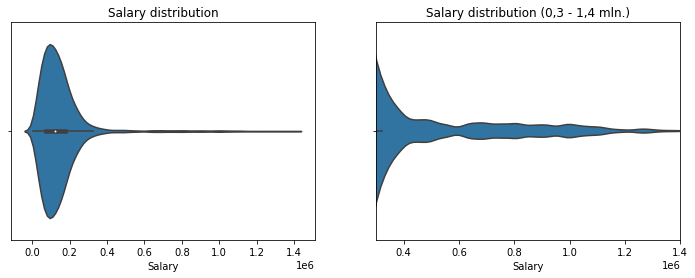

In [11]:
# Building a distribution of the customers salary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.violinplot(data['est_salary'], ax=ax1)
ax1.set_title('Salary distribution')
ax1.set_xlabel('Salary')
sns.violinplot(data['est_salary'], ax=ax2)
ax2.set_title('Salary distribution (0,3 - 1,4 mln.)')
ax2.set_xlabel('Salary')
ax2.set_xlim(300000, 1400000)
ax2.set_ylim(-0.05, 0.05)
plt.show()

**CONCLUSIONS:**
* 3.4% of clients have a salary above 400,000 rubles. At the same time, there are no individual values that stand out too much. 3.4% is a fairly large proportion of clients, and these are also probably important clients for the bank, because can hold a lot of money. It would be a mistake to exclude them all. Therefore, we leave the complete data in the dataset.

<a id="high_balances"></a> 
### Exploring clients with abnormally high balances

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


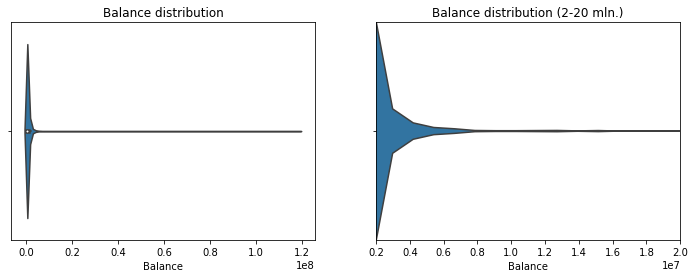

In [12]:
# Building a distribution of the customers balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.violinplot(data['balance'], ax=ax1)
ax1.set_title('Balance distribution')
ax1.set_xlabel('Balance')
sns.violinplot(data['balance'], ax=ax2)
ax2.set_title('Balance distribution (2-20 mln.)')
ax2.set_xlabel('Balance')
ax2.set_xlim(2000000, 20000000)
ax2.set_ylim(-0.05, 0.05)
plt.show()

After a balance of 7 million rubles, the number of people drops sharply. There are also extremely high values. Calculate user shares below a certain value.

In [13]:
# calculating the number of customers with a balance greater than different values
for i in [5, 6, 7, 7.5, 8, 10]:
    j = i * 1000000
    share = len(data.query('balance > @j')) / len(data) * 100
    print(f"The share of customers with a balance greater than {i} mln. rubles: {share:.2f}%")

The share of customers with a balance greater than 5 mln. rubles: 0.73%
The share of customers with a balance greater than 6 mln. rubles: 0.50%
The share of customers with a balance greater than 7 mln. rubles: 0.35%
The share of customers with a balance greater than 7.5 mln. rubles: 0.33%
The share of customers with a balance greater than 8 mln. rubles: 0.31%
The share of customers with a balance greater than 10 mln. rubles: 0.27%


We will remove clients with a balance of more than 7 million rubles from the dataset. There are very few such clients but they can have a very large impact on averages.

In [14]:
data = data[(data['balance'] <= 7000000) | (data['balance'].isna())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9965 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9965 non-null   int64  
 1   score          9965 non-null   float64
 2   city           9965 non-null   object 
 3   gender         9965 non-null   object 
 4   age            9940 non-null   float64
 5   equity         9965 non-null   int64  
 6   balance        7670 non-null   float64
 7   products       9965 non-null   int64  
 8   credit_card    9965 non-null   int64  
 9   last_activity  9965 non-null   int64  
 10  est_salary     9965 non-null   float64
 11  churn          9965 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1012.1+ KB


**CONCLUSIONS:**
* We have removed clients with a balance above 7 million rubles from the dataset so that these clients do not have too much influence on the calculation.

<a id="encoding"></a> 
### Encoding data for correlation calculations

In [16]:
# copying the required columns
data['city_is'] = data['city']
data['gender_is'] = data['gender']

# encoding
data = pd.get_dummies(data, columns=['city_is', 'gender_is'])

data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_is_Ростов,city_is_Рыбинск,city_is_Ярославль,gender_is_Ж,gender_is_М
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


**CONCLUSIONS:**
* We have encoded categorical variables for correlation analysis.

<a id="EDA"></a> 
## EDA

<a id="distributions"></a> 
### Building histograms of feature distribution

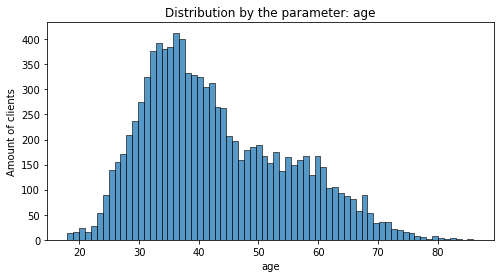

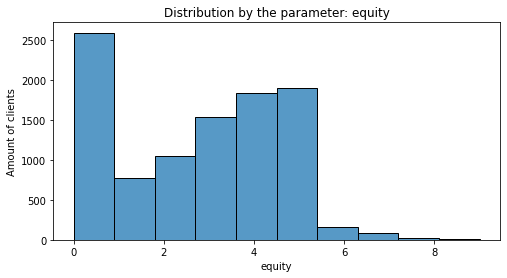

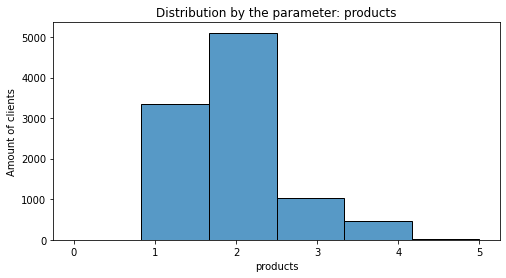

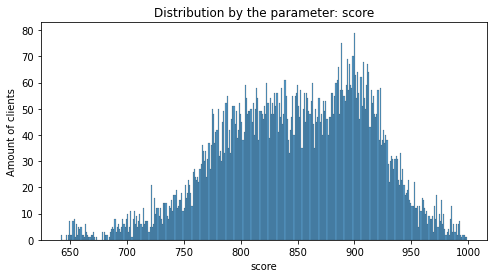

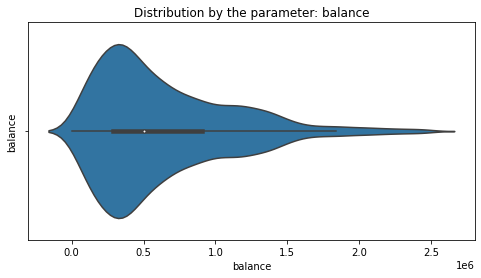

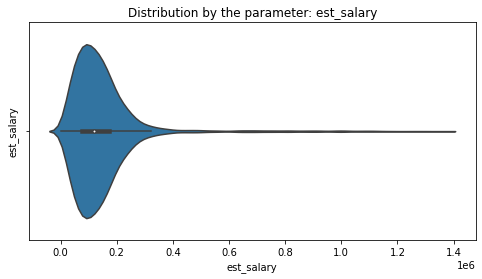

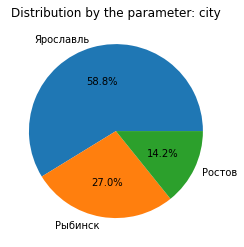

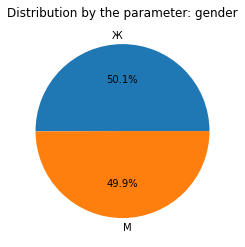

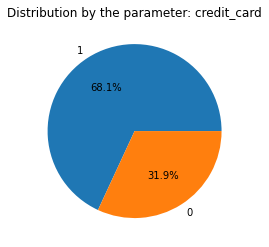

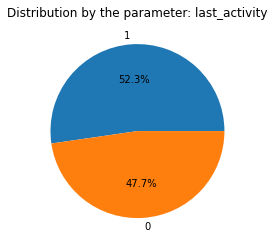

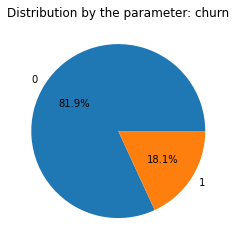

In [17]:
# distribution for numeric parameters
for param in ['age', 'equity', 'products', 'score']:
    plt.figure(figsize=(8,4))
    bins = int(data[param].max() - data[param].min() + 1)
    ax = sns.histplot(data=data, x=param, bins=bins)
    title = 'Distribution by the parameter: ' + param
    ax.set_title(title)
    ax.set_xlabel(param)
    ax.set_ylabel('Amount of clients')
    plt.show()

# distribution for continuous numerical parameters for a very large number of possible numbers (cut off values above 2.5 million)
for param in ['balance', 'est_salary']:
    plt.figure(figsize=(8,4))
    ax = sns.violinplot(data=data[data[param] <= 2500000], x=param)
    title = 'Distribution by the parameter: ' + param
    ax.set_title(title)
    ax.set_ylabel(param)
    #ax.set_ylabel('Количество клиентов')
    plt.show()

# distribution for categorical parameters
for param in ['city', 'gender', 'credit_card', 'last_activity', 'churn']:
    report = (
        data.groupby(by=param, as_index=False)
        .agg({'user_id': 'count'})
        .sort_values(by='user_id', ascending=False)
    )
    fig, ax = plt.subplots(figsize=(4,4))
    ax.pie(report['user_id'], labels=report[param], autopct='%0.1f%%')
    title = 'Distribution by the parameter: ' + param
    ax.set_title(title)
    plt.show()

**CONCLUSIONS:**
* Overall churn rate - 18%.
* The shares of men and women are equal.
* 68% customers have a credit card.
* 52% customers are active users.
* 59% clients are in Yaroslavl.
* Most of the clients are between 30 and 45 years old.
* Most customers have two or one product.
* Scoring is generally in the range of 770 to 940 points.
* The most frequent balance on the account is from 100 to 600 thousand rubles.
* The most common property rating is 0 points. At the same time, few have a score of 1. From 1 to 5 the score rises then drops sharply.

<a id="categorical"></a> 
### Building the distribution of categorical features in the context of churn

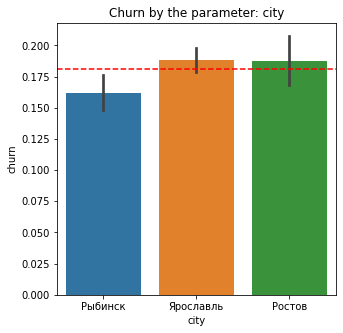

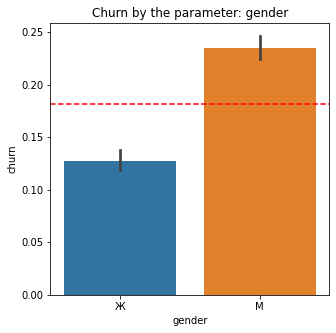

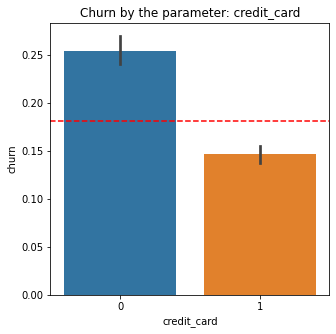

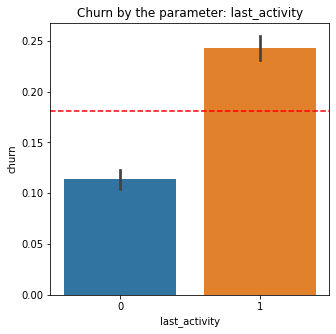

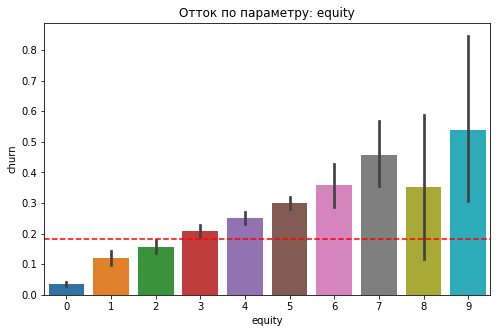

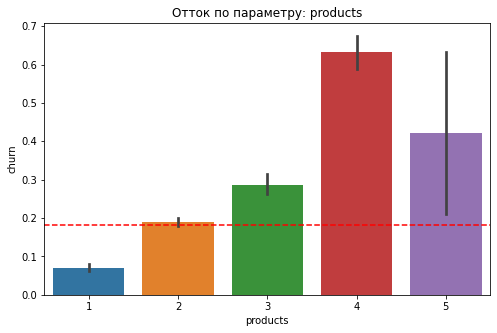

In [18]:
# distrubution for categorical parameters
for param in ['city', 'gender', 'credit_card', 'last_activity']:
    plt.figure(figsize=(5,5))
    ax = sns.barplot(data=data, y='churn', x=param)
    title = 'Churn by the parameter: ' + param
    ax.set_title(title)
    plt.axhline(data['churn'].mean(), linestyle='--', color='red')
    plt.show()

# distribution for categorical parameters with more options
for param in ['equity', 'products']:
    plt.figure(figsize=(8,5))
    # excluding the only case when the number of products is zero
    if param == 'products':
        ax = sns.barplot(data=data.query('products > 0'), y='churn', x=param)
    else:
        ax = sns.barplot(data=data, y='churn', x=param)
    title = 'Отток по параметру: ' + param
    ax.set_title(title)
    plt.axhline(data['churn'].mean(), linestyle='--', color='red')
    plt.show()

**CONCLUSIONS:**
* For Yaroslavl and Rostov, the churn is slightly more typical than for Rybinsk.
* For men, the churn is more typical than for women.
* Customers with a credit card leave less often.
* Active clients leave more often.

<a id="numeric"></a> 
### For numeric features, determining the ranges with a high churn

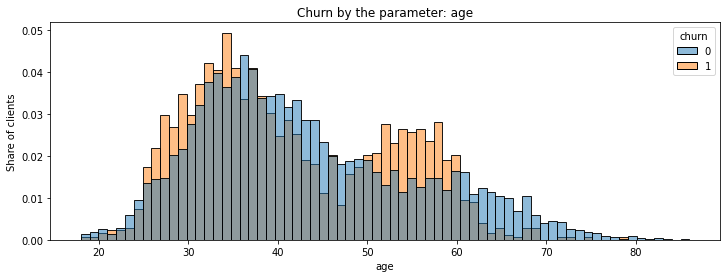

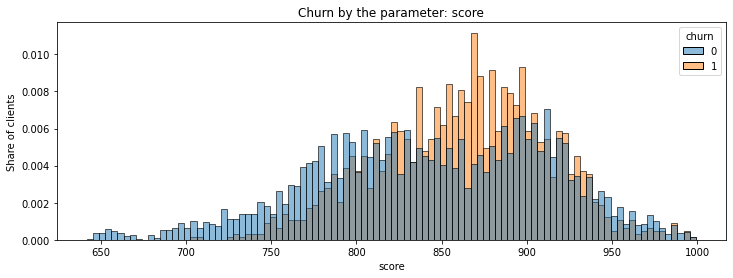

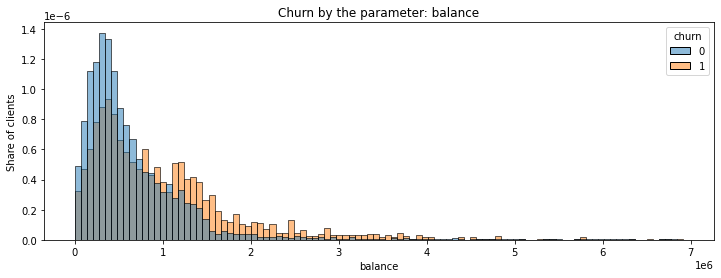

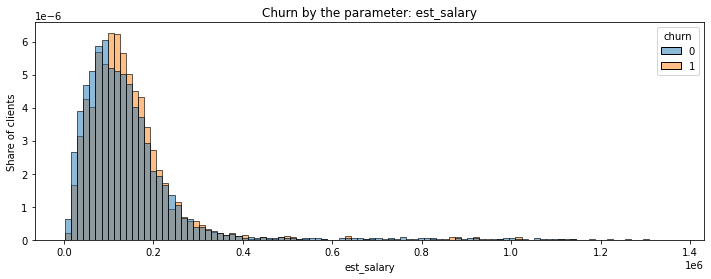

In [19]:
# distribution for numeric parameters
for param in ['age', 'score', 'balance', 'est_salary']:
    plt.figure(figsize=(12,4))
    
    # setting the number of intervals
    if data[param].nunique() <= 100:
        bins = int(data[param].max() - data[param].min() + 1)
    else:
        bins = 100
    
    # building the distribution
    ax = sns.histplot(data=data[data[param] <= 7000000], x=param, bins=bins, hue='churn', stat='density', common_norm=False)
    title = 'Churn by the parameter: ' + param
    ax.set_title(title)
    ax.set_xlabel(param)
    ax.set_ylabel('Share of clients')
    plt.show()

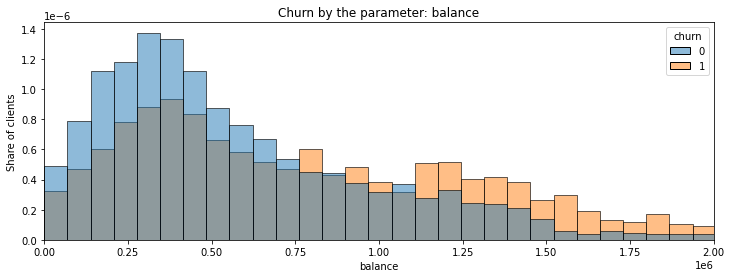

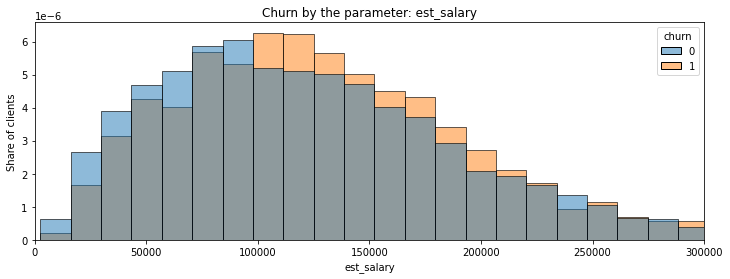

In [20]:
# limiting the tail for balance
plt.figure(figsize=(12,4))
ax = sns.histplot(data=data, x='balance', bins=100, hue='churn', stat='density', common_norm=False)
ax.set_title('Churn by the parameter: balance')
ax.set_xlabel('balance')
ax.set_ylabel('Share of clients')
plt.xlim(0, 2000000)
plt.show()

# limiting the tail for wage
plt.figure(figsize=(12,4))
ax = sns.histplot(data=data, x='est_salary', bins=100, hue='churn', stat='density', common_norm=False)
ax.set_title('Churn by the parameter: est_salary')
ax.set_xlabel('est_salary')
ax.set_ylabel('Share of clients')
plt.xlim(0, 300000)
plt.show()

**CONCLUSIONS:**
* There are two age ranges where the churn rate is higher: 25-35 years old and 50-60 years old.

In addition, customers which leave more often are customers:
* who have a property score of 3 or higher,
* who have 2 products or more,
* who have from 830 to 910 scoring points,
* with a balance above 750 thousand rubles,
* with a salary above from 100 to 210 thousand rubles.

<a id="profile"></a> 
### Compiling a customer profile in terms of churn

In [21]:
# creating a variable where we will write the table
columns = ['parameter', 'churn', 'no_churn', 'difference']
table = pd.DataFrame(columns=columns)

# calculating the average values of numeric variables and writing them down in a table
for param in ['age', 'balance', 'est_salary', 'score', 'credit_card', 'last_activity']:
    parameter = 'Av. ' + param
    churn = data[data['churn'] == 1][param].mean()
    no_churn = data[data['churn'] == 0][param].mean()
    difference = (churn / no_churn - 1) * 100
    table.loc[len(table.index)] = [parameter, churn, no_churn, difference]

# calculating the median values of the number of products, property, gender and city
for param in ['balance', 'est_salary', 'equity', 'products']:
    parameter = 'Median of ' + param
    churn = data[data['churn'] == 1][param].median()
    no_churn = data[data['churn'] == 0][param].median()
    difference = np.NaN
    table.loc[len(table.index)] = [parameter, churn, no_churn, difference]

# adding mode by gender and city
for param in ['gender', 'city']:
    parameter = 'Mode of ' + param
    churn = data[data['churn'] == 1][param].mode()[0]
    no_churn = data[data['churn'] == 0][param].mode()[0]
    difference = np.NaN
    table.loc[len(table.index)] = [parameter, churn, no_churn, difference]

# creating a table
table.style.format({'difference': '{:.1f}%'})

,parameter,churn,no_churn,difference
0,Av. age,41.426593,43.017578,-3.7%
1,Av. balance,1014732.986754,664258.074267,52.8%
2,Av. est_salary,143707.854474,146252.489032,-1.7%
3,Av. score,862.686600,845.159211,2.1%
4,Av. credit_card,0.550941,0.709646,-22.4%
5,Av. last_activity,0.700443,0.483515,44.9%
6,Median of balance,775333.240000,474379.890000,nan%
7,Median of est_salary,124848.695000,118068.800000,nan%
8,Median of equity,4.000000,3.000000,nan%
9,Median of products,2.000000,2.000000,nan%


**CONCLUSIONS:**
* Clients who leave have, on average, a significantly higher balance sheet, a higher median property score, and a higher average score.
* Gone clients are slightly younger.
* Gone customers are on average more active.
* Among the gone customers, the share of those with credit cards is lower.

<a id="correlation"></a> 
### Calculationg a correlation between the features, noting the strongest dependencies

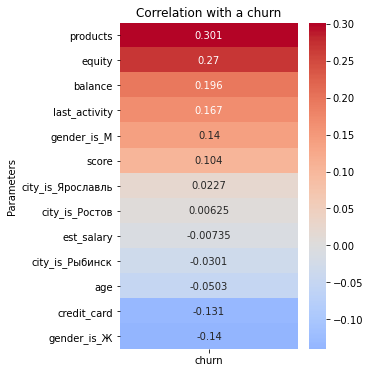

In [22]:
# creating a correlation matrix, leaving only the correlation column with a churn in it
corr_matrix = data.drop(columns='user_id').corr()
corr_matrix = corr_matrix[['churn']].sort_values('churn', ascending=False)

# building a hitmap without a line with a churn
plt.figure(figsize=(4, 6))
ax = sns.heatmap(corr_matrix[corr_matrix.index != 'churn'], annot=True, fmt='.3g', cmap='coolwarm', center=0)
plt.title('Correlation with a churn')
plt.ylabel('Parameters')
plt.show()

**CONCLUSIONS:**
* There is no noticeable or higher correlation on the Chaddock scale for any parameter.
* The only feature with a moderate positive correlation is the number of products.
* We can note a slight positive correlation of ownership, balance, activity, male gender and scoring, and a slight negative correlation of female gender and the presence of a credit card.

**INTERIM CONCLUSIONS:**
The main features that affect the churn:
* age: the main ranges are 25-35 years and 51-60 years;
* gender: men leave more often;
* moderate positive correlation: the number of products;
* slight positive correlation: property assessment, balance, activity, scoring;
* slight negative correlation: having a credit card.

<a id="hypo"></a> 
## Testing statistical hypotheses

In [23]:
# writing a function for determining Student's t-test
def ttest_function(data, separator, parameter, alpha, equal_var):
    '''
    The function takes values:
     - data array,
     - the value by which we divide the array,
     - the parameter whose influence is being studied,
     - significance level,
     - the equal_var parameter (True if the sample variances are assumed to be the same, otherwise False).
     And returns p-value.
    '''

    # testing the hypothesis
    result = st.ttest_ind(data[data[separator] == 1][parameter],\
        data[data[separator] == 0][parameter], equal_var=equal_var, nan_policy='omit')
    
    # calculating the ratio of the average in different groups
    ratio = data[data[separator] == 1][parameter].mean() / data[data[separator] == 0][parameter].mean() * 100 - 100

    # outputing p-value and conclusion
    print('p-value: {0:.5f}'.format(result.pvalue))

    print('Mean difference: {0:.1f}%'.format(ratio))

    if result.pvalue < alpha:
        print('Rejecting the null hypothesis')
    else:
        print("Can't reject the null hypothesis")

In [24]:
# writing a function for determining the Mann-Whitney test
def mannwhitney_function(data, separator, parameter, alpha):
    '''
    The function takes values:
     - data array,
     - the value by which we divide the array,
     - the parameter whose influence is being studied,
     - significance level.
     And returns p-value.
    '''

    # testing the hypothesis
    results = st.mannwhitneyu(data[data[separator] == 1][parameter], data[data[separator] == 0][parameter])

    print('p-value: {0:.5f}'.format(result.pvalue))
    
    if result.pvalue < alpha:
        print('Rejecting the null hypothesis')
    else:
        print("Can't reject the null hypothesis")

In [25]:
# writing a function for testing the hypothesis of equality of shares
def equality_function(data, separator, parameter, alpha):
    '''
    The function takes values:
     - data array,
     - the value by which we divide the array,
     - the parameter whose influence is being studied,
     - significance level.
     And returns p-value.
    '''

    # determining the total number of people separated by a separator
    totals = [data[data[separator] == 1][parameter].count(), data[data[separator] == 0][parameter].count()]
    
    # calculating how many people in both cases have the trait
    are_positive = [data[data[separator] == 1][parameter].sum(), data[data[separator] == 0][parameter].sum()]

    # calculating the proportions in both groups and in the total
    p1 = are_positive[0] / totals[0]
    p2 = are_positive[1] / totals[1]
    p_combined = (are_positive[0] + are_positive[1]) / (totals[0] + totals[1])

    # calculating z-value
    z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1 / totals[0] + 1 / totals[1]))

    # setting the standard normal distribution
    distr = st.norm(0, 1)

    # calculating p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    # calculating the ratio of the average in different groups
    ratio = data[data[separator] == 1][parameter].mean() / data[data[separator] == 0][parameter].mean() * 100 - 100

    print('p-value: {0:.5f}'.format(p_value))

    print('Mean difference: {0:.1f}%'.format(ratio))
    
    if p_value < alpha:
        print('Rejecting the null hypothesis')
    else:
        print("Can't reject the null hypothesis")

<a id="hypo1"></a> 
### Testing the hypothesis 1 about the equality of average incomes between clients who left and those who stayed

**Null Hypothesis:** Average earnings of customers who left and those who stayed are equal.

**Alternative hypothesis:** There is a statistically significant difference between the earnings of left and retained customers.

To test the hypothesis, we use the method ttest_ind because universes do not depend on each other and the universe is large enough. This means that, according to the CLT, the sample means are normally distributed. Because universes sizes are very different, set the equal_var=False parameter.

In [26]:
# checking the hypothesis with the function of calculating the t-test
ttest_function(data, 'churn', 'est_salary', 0.05, False)

p-value: 0.39049
Mean difference: -1.7%
Can't reject the null hypothesis


**CONCLUSION:**
* We cannot reject the hypothesis about the equality of average incomes between left and remaining customers.

<a id="hypo2"></a> 
### Testing hypothesis 2 about the equality of the average scoring value between customers who left and those who stayed

**Null hypothesis:** The average scores of customers who left and those who stayed are equal.

**Alternative hypothesis:** There are statistically significant differences between the scoring of left and remaining customers.

To test the hypothesis, we use the ttest_ind method, because universes do not depend on each other and the universe is large enough. This means that, according to the CLT, the sample means are normally distributed. Because unniverses sizes are very different, set the equal_var=False parameter.

In [27]:
# checking the hypothesis with the function of calculating the t-test
ttest_function(data, 'churn', 'score', 0.05, False)

p-value: 0.00000
Mean difference: 2.1%
Rejecting the null hypothesis


**CONCLUSION:**
* We reject the null hypothesis. There are statistically significant differences in scoring between left and retained customers.

<a id="hypo3"></a> 
### Testing the hypothesis 3 about the equality of the distribution by city between the clients who left and those who stayed

**Null hypothesis:** There is no difference in the share of cities of residence between customers who left and those who stayed.

**Alternative hypothesis:** There are statistically significant differences in the share of cities of residence of left and remaining customers.

To test the hypothesis, the t-test is not suitable, because there are no numerical distributions of the parameter. We will use hypothesis testing for equality of shares.

In [28]:
# for Yaroslavl
equality_function(data, 'churn', 'city_is_Ярославль', 0.05)

p-value: 0.02352
Mean difference: 5.0%
Rejecting the null hypothesis


In [29]:
# for Rybinsk
equality_function(data, 'churn', 'city_is_Рыбинск', 0.05)

p-value: 0.00270
Mean difference: -12.5%
Rejecting the null hypothesis


In [30]:
# for Rostov
equality_function(data, 'churn', 'city_is_Ростов', 0.05)

p-value: 0.53291
Mean difference: 4.0%
Can't reject the null hypothesis


**CONCLUSIONS:**
* We rejected the null hypothesis for each of Yaroslavl and Rybinsk, which means there are statistically significant differences.
* In Yaroslavl, the share of those who left is above average, in Rybinsk it is below than average.
* We were unable to reject the null hypothesis for Rostov.

<a id="int_summary"></a> 
## Interim Summary

<a id="int_conclusions"></a> 
### Interim conclusions

* The overall churn rate is 18.1%.
* Gender, credit card, activity influence churn.
* Dependence of churn on age is non-linear.
* People living in Yaroslavl are more likely to churn.
* There is no noticeable or higher correlation on the Chaddock scale for any parameter. The strongest correlation with churn is for product quantity and property valuation.
* Balance sheet and scoring have a slight positive correlation with churn, while wages have almost no correlation with it.

<a id="features"></a> 
### Features that affect customer churn

Features that positively affect the rate of care:
* age (non-linear, main outflow at ages 25-35 and 50-60)
* male gender,
* activity: active customers leave more often,
* lack of a credit card,
* balance above 750,000 rubles,
* place of residence is Yaroslavl,
* the number of products is from 2 and more,
* property assessment is from 3 and above,
* scoring in the range of 830-910

<a id="segments"></a> 
## Segments formation

**Approach description:**

1. Based on the features highlighted above, we calculate the number of customers, the churn rate and the relative churn rate (relative to the average).
2. We calculate the joint influence of the features in pairs. For this:
     * We go through the list of parameters above, combining two conditions;
     * For each association, we check the number of people (need more than 500);
     * For each union, we calculate churn_rate and relative_churn_rate;
     * For each union, we calculate the cooperation rate: relative_churn_rate divided by the product of the relative_churn_rate of the individual parameters. If the coefficient of cooperation is greater than 1, then the parameters "reinforce" each other, combine well;
     * Build cross tables churn rate and cooperation rate: if the number of people is more than 500, add churn_rate and cooperation rate to the table.
3. According to the table, we select pairs of features that most effectively complement each other (we need to make 3-4 pairs that form the final segments).
4. We check whether these pairs can be strengthened by adding a third feature from among those not included in the pairs.
5. We form the final list.

<a id="individual"></a> 
### Calculating the number of customers, the churn rate and the relative churn rate for each individual feature that affects the churn

In [31]:
# writing a function that calculate the number of customers and the churn rate by the condition
def segment_creator(data, condition):
    '''
    The function receives data and a condition for a query.
    The function returns the number of people in the segment and the churn rate.
    '''
    
    # calculating the number of clients, the number of left clients and the churn rate by the segment
    segment_volume = len(data.query(condition))
    churn_volume = data.query(condition)['churn'].sum()
    churn_rate = data.query(condition)['churn'].mean()
    
    return condition, segment_volume, churn_volume, churn_rate

In [32]:
# making a list of conditions to make segments
condition_list = [
    'gender == "М"',
    '(age >= 25) & (age <= 35)',
    '(age >= 50) & (age <= 60)',
    'city_is_Ярославль == 1',
    'products >= 2',
    'equity >= 3',
    'balance >= 750000',
    'last_activity == 1',
    'credit_card == 0',
    '(score >= 830) & (score <= 910)'
]

In [33]:
# creating the table for a list of segments
simple_segments = pd.DataFrame(columns=['condition', 'volume', 'churn_volume', 'churn_rate', 'relative_churn_rate'])

# writing the churn rate of all the data to a variable
av_churn_rate = data['churn'].mean()

# applying the fuction to the list of conditions, adding relative churn rate
for condition in condition_list:
    condition, segment_volume, churn_volume, churn_rate = segment_creator(data, condition)
    relative_churn_rate = churn_rate / av_churn_rate
    simple_segments.loc[len(simple_segments)] = [condition, segment_volume, churn_volume, churn_rate, relative_churn_rate]

# printing total churn rate
print('Total churn rate: {0:.3f}'.format(av_churn_rate))

# printing the table with a sorting by the churn rate
simple_segments = simple_segments.sort_values('churn_rate', ascending=False).reset_index().drop(columns='index')
simple_segments

Total churn rate: 0.181


,condition,volume,churn_volume,churn_rate,relative_churn_rate
0,balance >= 750000,2669,927,0.347321,1.916420
1,(age >= 50) & (age <= 60),1761,465,0.264055,1.456979
2,equity >= 3,5547,1457,0.262665,1.449309
3,credit_card == 0,3180,811,0.255031,1.407192
4,last_activity == 1,5210,1265,0.242802,1.339715
5,(score >= 830) & (score <= 910),4277,1037,0.242460,1.337824
6,products >= 2,6629,1572,0.237140,1.308471
7,"gender == ""М""",4976,1170,0.235129,1.297374
8,(age >= 25) & (age <= 35),3044,660,0.216820,1.196352
9,city_is_Ярославль == 1,5855,1104,0.188557,1.040403


**CONCLUSIONS:**
* For each of the 10 churn segments, we calculated the number of customers, the number of left customers, churn and relative churn. Segments were prioritized by churn rate.
* The strongest of the churn factors is the balance of more than 750,000 rubles. Also strong factors are age 50-60, property score >= 3 and no credit card.
* The weakest factor is Yaroslavl. Also, a low relative rate of refinement is for the age of 25-35.

<a id="pairs"></a> 
### Applying factors together in pairs to obtain overall scores for every pair of factors

In [34]:
# making a heading for a table
columns = ['condition']
for cond in simple_segments['condition'].values:
    columns.append(cond)

# making tables of intersections
table_churn = pd.DataFrame(columns=columns)
table_cooperation = pd.DataFrame(columns=columns)
table_volume = pd.DataFrame(columns=columns)
table_churn_volume = pd.DataFrame(columns=columns)

# starting the cycle
for i, row1 in simple_segments.iterrows():
    
    # filling the value of the condition column
    table_churn.loc[i, 'condition'] = row1['condition']
    table_cooperation.loc[i, 'condition'] = row1['condition']
    table_volume.loc[i, 'condition'] = row1['condition']
    table_churn_volume.loc[i, 'condition'] = row1['condition']

    # filling the table
    for j, row2 in simple_segments.iterrows():

        # filtering rows
        filtered_rows = data.query(row1['condition']).query(row2['condition'])

        # calculating the amount of clients
        volume = len(filtered_rows)

        # calculating the amount of left clients and the churn rate
        total_churn = filtered_rows['churn'].sum()
        total_churn_rate = filtered_rows['churn'].mean()
        
        # calculating relative churn rate
        relative_churn_rate = total_churn_rate / av_churn_rate

        # calculating the product of churn rates of factors for comparing with a final relative churn rate
        churn_target = row1['relative_churn_rate'] * row2['relative_churn_rate']

        # calculating the cooperation rate
        cooperation = relative_churn_rate / churn_target

        # filling tables
        if volume >= 500:
            table_churn.loc[i, row2['condition']] = total_churn_rate
            table_cooperation.loc[i, row2['condition']] = cooperation
            table_volume.loc[i, row2['condition']] = volume
            table_churn_volume.loc[i, row2['condition']] = total_churn
        else:
            table_churn.loc[i, row2['condition']] = np.NaN
            table_cooperation.loc[i, row2['condition']] = np.NaN
            table_volume.loc[i, row2['condition']] = np.NaN
            table_churn_volume.loc[i, row2['condition']] = np.NaN

# putting conditions to indexes and converting values to the type "float"
table_churn = table_churn.set_index('condition').astype('float')
table_cooperation = table_cooperation.set_index('condition').astype('float')
table_volume = table_volume.set_index('condition').astype('float')
table_churn_volume = table_churn_volume.set_index('condition').astype('float')

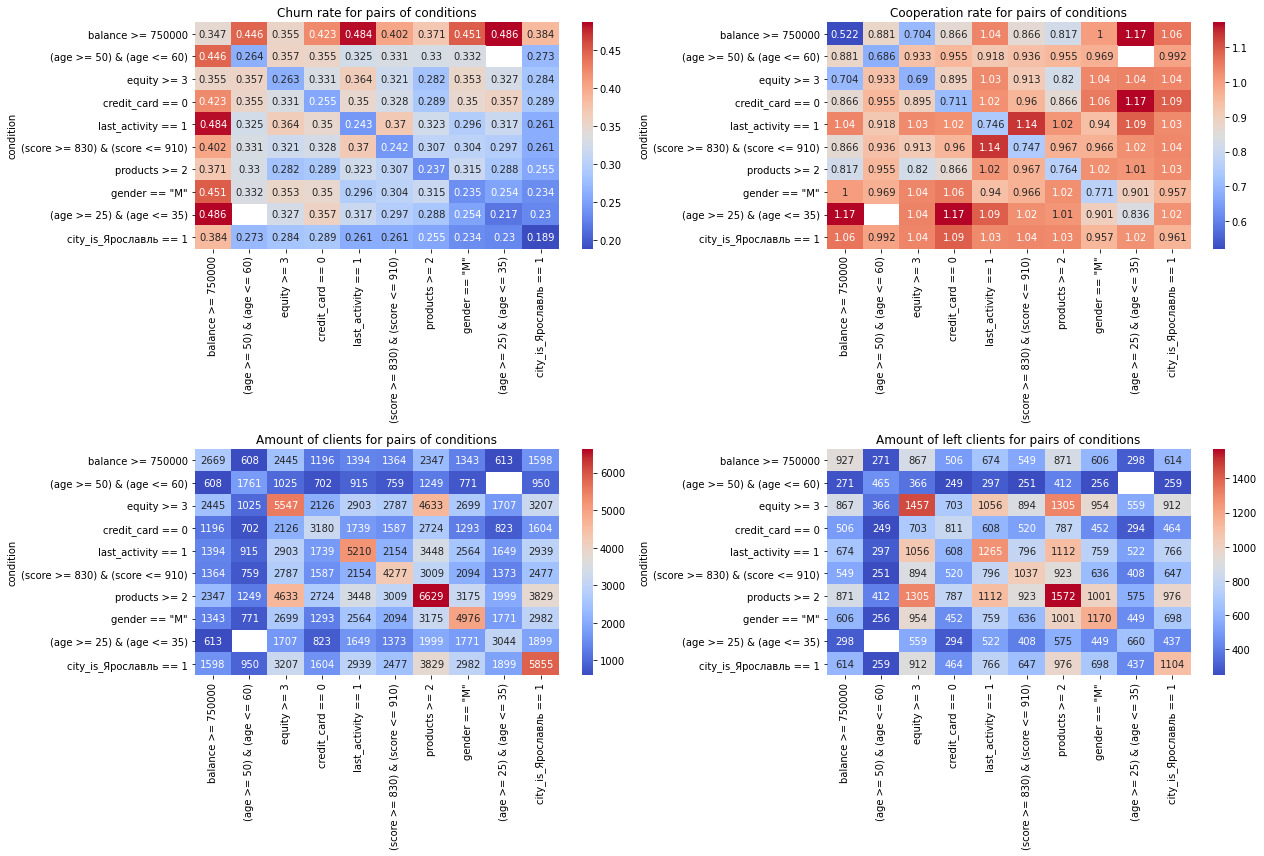

In [35]:
# making heatmaps
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
sns.heatmap(table_churn, cmap='coolwarm', annot= True , fmt='.3g', ax=ax1)
ax1.set_title('Churn rate for pairs of conditions')
sns.heatmap(table_cooperation, cmap='coolwarm', annot= True , fmt='.3g', ax=ax2)
ax2.set_title('Cooperation rate for pairs of conditions')
sns.heatmap(table_volume, cmap='coolwarm', annot= True , fmt='.0f', ax=ax3)
ax3.set_title('Amount of clients for pairs of conditions')
sns.heatmap(table_churn_volume, cmap='coolwarm', annot= True , fmt='.0f', ax=ax4)
ax4.set_title('Amount of left clients for pairs of conditions')
plt.tight_layout()
plt.show()

**CONCLUSIONS:**
* For the balance, the best intersection is with age 25-35.
* Age 50-60 have no ideal intersections, the best are with men, property evaluation, lack of a credit card, number of products.
* Property evaluation has good intersections with activity, men and age 25-35.
* The absence of a credit card has the best intersection with the age of 25-35, also good is with men.
* Activity and scoring have better overlap with each other.
* The number of products has good intersections with activity and men.
* Men have the best crossing with the absence of the credit card. Also good crossing are with the valuation of the property and the number of products.
* Age 25-35 has better intersections with balance and no credit card.

**Making segments:**
* Crossing the balance over 750,000 and age 25-35.
* Combine activity and scoring 830-910. This is a large sample, we can consider another limitation.
* Products don't overlap well with the rest, but they can be used to improve activity and scoring results.
* In other cases, two options are possible: male + property valuation >=3 and age 50-60 + no credit card or male + no credit card and age 50-60 + property valuation >=3. Let's check out these options.

<a id="all_intersections"></a> 
### Collecting intersections of two and three conditions into separate dataframes, calculate conditions for them

In [36]:
# creating the dataframe for final segments of the crossing of two segments
complex_segments_2 = pd.DataFrame(
    columns=['condition_1', 'condition_2', 'volume', 'churn_volume', 'churn_rate', 'relative_churn_rate', 'cooperation']
)

# running the cycle to all the combinations of two factors
for i, row1 in simple_segments.iterrows():
    for j, row2 in simple_segments.iterrows():

        # filtering rows
        filtered_rows = data.query(row1['condition']).query(row2['condition'])

        # calculating the amount of customers
        volume = len(filtered_rows)

        # calculating the amount of left customers and the churn rate
        total_churn = filtered_rows['churn'].sum()
        total_churn_rate = filtered_rows['churn'].mean()
        
        # calculating the relative churn rate
        relative_churn_rate = total_churn_rate / av_churn_rate

        # calculating the product of churn rates of components for comparing with the relative churn rate
        churn_target = row1['relative_churn_rate'] * row2['relative_churn_rate']

        # calculating the cooperation rate
        cooperation = relative_churn_rate / churn_target

        # setting the selection condition and writing suitable combinations to the new dataframe
        if i < j:
            complex_segments_2.loc[len(complex_segments_2)] = [
                row1['condition'], row2['condition'], volume, total_churn, total_churn_rate, relative_churn_rate, cooperation
            ]

# printing the table
complex_segments_2.head()

,condition_1,condition_2,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
0,balance >= 750000,(age >= 50) & (age <= 60),608,271,0.445724,2.459378,0.880808
1,balance >= 750000,equity >= 3,2445,867,0.354601,1.956590,0.704447
2,balance >= 750000,credit_card == 0,1196,506,0.423077,2.334419,0.865635
3,balance >= 750000,last_activity == 1,1394,674,0.483501,2.667821,1.039091
4,balance >= 750000,(score >= 830) & (score <= 910),1364,549,0.402493,2.220841,0.866219


In [37]:
# creating the dataframe for final segments of the crossing of three segments
complex_segments_3 = pd.DataFrame(
    columns=['condition_1', 'condition_2', 'condition_3', 'volume', 'churn_volume', 'churn_rate', 'relative_churn_rate', 'cooperation']
)

# running the cycle to all the combinations of two factors
for i, row1 in simple_segments.iterrows():
    for j, row2 in simple_segments.iterrows():
        for k, row3 in simple_segments.iterrows():

            # filtering rows
            filtered_rows = data.query(row1['condition']).query(row2['condition']).query(row3['condition'])

            # calculating the amount of customers
            volume = len(filtered_rows)

            # calculating the amount of left customers and the churn rate
            total_churn = filtered_rows['churn'].sum()
            total_churn_rate = filtered_rows['churn'].mean()
        
            # calculating the relative churn rate
            relative_churn_rate = total_churn_rate / av_churn_rate

            # calculating the product of churn rates of components for comparing with the relative churn rate
            churn_target = row1['relative_churn_rate'] * row2['relative_churn_rate'] * row3['relative_churn_rate']

            # calculating the cooperation rate
            cooperation = relative_churn_rate / churn_target

            # setting the selection condition and writing suitable combinations to the new dataframe
            if i < j and j < k:
                complex_segments_3.loc[len(complex_segments_3)] = [
                    row1['condition'], row2['condition'], row3['condition'], volume, total_churn, total_churn_rate, relative_churn_rate, cooperation
                ]

# printing the table
complex_segments_3.head()

,condition_1,condition_2,condition_3,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
0,balance >= 750000,(age >= 50) & (age <= 60),equity >= 3,557,251,0.450628,2.486441,0.614431
1,balance >= 750000,(age >= 50) & (age <= 60),credit_card == 0,317,168,0.529968,2.924217,0.744239
2,balance >= 750000,(age >= 50) & (age <= 60),last_activity == 1,328,187,0.570122,3.145773,0.840952
3,balance >= 750000,(age >= 50) & (age <= 60),(score >= 830) & (score <= 910),333,168,0.504505,2.783714,0.745215
4,balance >= 750000,(age >= 50) & (age <= 60),products >= 2,542,256,0.472325,2.606155,0.713333


In [38]:
# writing the function for a dataframe of two segments filtration
def segments_2_filter(condition_list):
    '''
    A list of lists is always passed to the function.
    The function filters rows according to the data specified in the list.
    Data inside nested lists is ORed, nested lists are ANDed.
    '''
    if len(condition_list) == 1:
        filtered_segments = (
            complex_segments_2.query('(condition_1 in @condition_list[0]) | (condition_2 in @condition_list[0])')
            .sort_values('cooperation', ascending=False)
        )
    elif len(condition_list) == 2:
        filtered_segments = (
            complex_segments_2.query('(condition_1 in @condition_list[0]) | (condition_2 in @condition_list[0])')
            .query('(condition_1 in @condition_list[1]) | (condition_2 in @condition_list[1])')
            .sort_values('cooperation', ascending=False)
        )
    return filtered_segments

In [39]:
# writing the function for a dataframe of three segments filtration
def segments_3_filter(condition_list):
    '''
    A list of lists is always passed to the function.
    The function filters rows according to the data specified in the list.
    Data inside nested lists is ORed, nested lists are ANDed.
    '''
    if len(condition_list) == 1:
        filtered_segments = (
            complex_segments_3.query('(condition_1 in @condition_list[0]) | (condition_2 in @condition_list[0]) | (condition_3 in @condition_list[0])')
            .sort_values('cooperation', ascending=False)
        )
    elif len(condition_list) == 2:
        filtered_segments = (
            complex_segments_3.query('(condition_1 in @condition_list[0]) | (condition_2 in @condition_list[0]) | (condition_3 in @condition_list[0])')
            .query('(condition_1 in @condition_list[1]) | (condition_2 in @condition_list[1]) | (condition_3 in @condition_list[1])')
            .sort_values('cooperation', ascending=False)
        )
    elif len(condition_list) == 3:
        filtered_segments = (
            complex_segments_3.query('(condition_1 in @condition_list[0]) | (condition_2 in @condition_list[0]) | (condition_3 in @condition_list[0])')
            .query('(condition_1 in @condition_list[1]) | (condition_2 in @condition_list[1]) | (condition_3 in @condition_list[1])')
            .query('(condition_1 in @condition_list[2]) | (condition_2 in @condition_list[2]) | (condition_3 in @condition_list[2])')
            .sort_values('cooperation', ascending=False)
        )
    return filtered_segments

**CONCLUSIONS:**
* We prepared data for the final segments selection.
* We prepared functions for a segments filtration.

<a id="final_segments"></a> 
### Final segments selection

In [40]:
# collecting the final list of segments
final_segments = pd.DataFrame(
    columns=['condition_1', 'condition_2', 'condition_3', 'volume', 'churn_volume', 'churn_rate', 'relative_churn_rate', 'cooperation']
)

# adding the crossing of the balance above 750k and age 25-35
condition_list = [['balance >= 750000'], ['(age >= 25) & (age <= 35)']]
segment = segments_2_filter(condition_list)

final_segments = pd.concat([final_segments, segment])
final_segments

,condition_1,condition_2,condition_3,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
7,balance >= 750000,(age >= 25) & (age <= 35),NaN,613,298,0.486134,2.682349,1.169946


Checking if the amount of products >=2 improve the crossing of activity and scoring in 830-910

In [41]:
# only activity and scoring
condition_list = [['last_activity == 1'], ['(score >= 830) & (score <= 910)']]
segments_2_filter(condition_list)

,condition_1,condition_2,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
30,last_activity == 1,(score >= 830) & (score <= 910),2154,796,0.369545,2.039046,1.137668


In [42]:
# now see the crossing of activity, scoring, and amount of products
condition_list = [['last_activity == 1'], ['(score >= 830) & (score <= 910)'], ['products >= 2']]
segments_3_filter(condition_list)

,condition_1,condition_2,condition_3,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
100,last_activity == 1,(score >= 830) & (score <= 910),products >= 2,1527,712,0.466274,2.572767,1.097046


Despite the fact that the cooperation rate has decreased slightly, the churn rate has increased significantly. Therefore, we add this option to the final list.

In [43]:
# adding the crossing of activity, scoring, and amount of products
condition_list = [['last_activity == 1'], ['(score >= 830) & (score <= 910)'], ['products >= 2']]
segment = segments_3_filter(condition_list)

final_segments = pd.concat([final_segments, segment])
final_segments

,condition_1,condition_2,condition_3,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
7,balance >= 750000,(age >= 25) & (age <= 35),NaN,613,298,0.486134,2.682349,1.169946
100,last_activity == 1,(score >= 830) & (score <= 910),products >= 2,1527,712,0.466274,2.572767,1.097046


Seeing the crossing of men and age in 50-60 with the property valuation and abcense of the credit card.

In [44]:
# first pair is men and age in 50-60, second pair is the property valuation and abcense of the credit card
condition_list = [['gender == "М"', '(age >= 50) & (age <= 60)'], ['credit_card == 0', 'equity >= 3']]
segments_2_filter(condition_list)

,condition_1,condition_2,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
27,credit_card == 0,"gender == ""М""",1293,452,0.349575,1.928854,1.056528
21,equity >= 3,"gender == ""М""",2699,954,0.353464,1.950316,1.037240
10,(age >= 50) & (age <= 60),credit_card == 0,702,249,0.354701,1.957140,0.954587
9,(age >= 50) & (age <= 60),equity >= 3,1025,366,0.357073,1.970229,0.933045


Generally, the abcense of the credit card give a slightly better effect than the property valuation. There is no big difference, how to cross. Let's add Yaroslavl.

In [45]:
# adding Yaroslavl to a previous segments
condition_list = [['gender == "М"', '(age >= 50) & (age <= 60)'], ['credit_card == 0', 'equity >= 3'], ['city_is_Ярославль == 1']]
segments_3_filter(condition_list)

,condition_1,condition_2,condition_3,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
98,credit_card == 0,"gender == ""М""",city_is_Ярославль == 1,628,251,0.399682,2.205330,1.161057
48,(age >= 50) & (age <= 60),credit_card == 0,city_is_Ярославль == 1,347,140,0.403458,2.226169,1.043638
83,equity >= 3,"gender == ""М""",city_is_Ярославль == 1,1572,575,0.365776,2.018250,1.031685
42,(age >= 50) & (age <= 60),equity >= 3,city_is_Ярославль == 1,562,215,0.382562,2.110871,0.960828


The combination of men, lack of a credit card and Yaroslavl gives the best effect. We approve this option, and according to the residual principle, we will collect the age of 50-60 and the property valuation >= 3.

In [46]:
# adding the combination of men, lack of a credit card and Yaroslavl
condition_list = [['gender == "М"'], ['credit_card == 0'], ['city_is_Ярославль == 1']]
segment = segments_3_filter(condition_list)

final_segments = pd.concat([final_segments, segment])

# adding the crossing of age in 50-60 and the property valuation
condition_list = [['(age >= 50) & (age <= 60)'], ['equity >= 3']]
segment = segments_2_filter(condition_list)

final_segments = pd.concat([final_segments, segment])
final_segments

,condition_1,condition_2,condition_3,volume,churn_volume,churn_rate,relative_churn_rate,cooperation
7,balance >= 750000,(age >= 25) & (age <= 35),NaN,613,298,0.486134,2.682349,1.169946
100,last_activity == 1,(score >= 830) & (score <= 910),products >= 2,1527,712,0.466274,2.572767,1.097046
98,credit_card == 0,"gender == ""М""",city_is_Ярославль == 1,628,251,0.399682,2.205330,1.161057
9,(age >= 50) & (age <= 60),equity >= 3,NaN,1025,366,0.357073,1.970229,0.933045


**CONCLUSIONS:**

We have formed four outflow segments:
* Clients aged 25-35 with a balance above 750,000 rubles,
* Active customers with a score of 830 to 910 using two or more products,
* Men served by the Yaroslavl branch of the bank who do not have a credit card,
* Clients aged 50-60 with a property rating of 3 or higher.

<a id="final_conclusions"></a> 
## Final conclutions

<a id="final_conc_segments"></a> 
### Final conclutions by the segments

**Customers aged 25-35 with a balance above 750,000 rubles**

Segment with the highest churn rate. There are few such clients (since there are not many people who have more than 750,000 rubles in their account), but they are important for the bank, because the bank can get more income from such clients. Due to their young age and quite a lot of money, these people may have a need to actively manage their finances through the application. Perhaps there are some problems with it.

**Active customers with a score of 830 to 910 using two or more products**

Largest of the churn segments with the highest number of left customers. These are people who are quite active and use banking services a lot. The fact that they often leave indicates that they are either dissatisfied with some services or other banks offer more favorable conditions to active users. Also, these people have a fairly high scoring, so these clients can also be quite important for the bank.

**Men served by the Yaroslavl branch of the bank who do not have a credit card**

A small segment with the least number of lost customers.

**Customers aged 50-60 with a property rating of 3 or higher**

Quite a large segment, the second in terms of number and the second in terms of the number of customers who left, although it is also the smallest in terms of churn rate. You should try to keep these people while they are at this age because older clients are likely to be more conservative and less willing to leave. Perhaps these clients have some specific requirements for the bank, possibly related to coming retirement.

<a id="prioritization"></a> 
###  Churn segments prioritization

Prioritization of churn segments depends on the strategy the bank chooses to use.

If the bank prefers to use the strategy of offering customers some special conditions personally by calling them, then it is recommended to prioritize the segments by churn rate, because a call to each client will potentially be more important and the bank does not have automated call and mailing systems. In this case, the priorities are:
1. Clients aged 25-35 with a balance above 750,000 rubles
2. Active customers with a score of 830 to 910 using two or more products
3. Men served by the Yaroslavl branch of the bank who do not have a credit card
4. Clients aged 50-60 with a property rating of 3 or higher

If the bank decides to use a less individual approach to develop mass offers to customers then segments should be prioritized by the number of customers who have left, because segment size will matter:
1. Active customers with a score of 830 to 910 using two or more products
2. Clients aged 50-60 with a property rating of 3 or higher
3. Clients aged 25-35 with a balance above 750,000 rubles
4. Men served by the Yaroslavl branch of the bank who do not have a credit card

<a id="reco"></a> 
### Recommendations

1. Conduct telephone interviews or focus groups with representatives of the segments "Customers aged 25-35 with a balance above 750,000 rubles" and "Active customers with a score of 830 to 910 using two or more products" in order to identify problems in the current services or conditions of the bank. These clients are likely to leave because they do not receive the required range or quality of services from the bank.
1. Analyze competitors' offers for an active and highly profitable audience.
1. Based on points 1-2, identify room for improvement and improve conditions or services for customers from these segments.
1. To offer men who are served in the Yaroslavl branch of the bank and who do not have a credit card to issue one. Organize a call with the appropriate offer.
1. Analyze the offers of competitors related to servicing people of pre-retirement age. Based on this analysis, prepare a proposal for this audience.